# CS421 Project: Appendix (Exploratory Data Analysis)
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

In this notebook, we explore statistics related to the dataset, and determine which additional features to create in order to create better prediction models.

## Exploratory Data Analysis

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the Seaborn style
sns.set_style("whitegrid")
%matplotlib inline

In [22]:
data  = np.load("data/Week1/first_batch_regression_labelled.npz")
X     = data["X"]
y     = data["yy"]
y_cat = data["yy_cat"]

# Load dataframes
X     = pd.DataFrame(X, columns=["user", "item", "rating"])
y     = pd.DataFrame(y, columns=["user", "label"])
y_cat = pd.DataFrame(y_cat, columns=["user", "label", "anomtype"])

# Parse to correct types
y     = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})

In [23]:
# We found that there are quite a few duplicates (i.e. a user rated an item more than once)
# We assume that a user's final rating is the final decision, and we keep that

X_no_dupes = X.drop_duplicates(subset=["user", "item"], keep="last")

print(X_no_dupes.shape)

(263077, 3)


In [24]:
X_no_dupes

,user,item,rating
0,0,94,2
1,0,90,1
2,0,97,2
3,0,100,4
4,0,101,2
...,...,...,...
288200,899,515,3
288201,899,522,1
288202,899,526,4
288203,899,592,2


In [25]:
X_no_dupes["rating"].value_counts()

rating
4    92457
3    75621
5    35972
2    35621
1    20819
0     2587
Name: count, dtype: int64

### Mean ratings and rating percentages
Firstly, we hypothesized that the different anomtypes may have noise that skew the datapoints to have different means and rating percentages, so we decided to plot some graphs to check it out.

,user,mean_rating,label,anomtype,group
0,0,2.435644,NaN,NaN,Unknown anomtype
1,1,2.698507,NaN,NaN,Unknown anomtype
2,2,3.904580,NaN,NaN,Unknown anomtype
3,3,3.801370,NaN,NaN,Unknown anomtype
4,4,4.373737,NaN,NaN,Unknown anomtype
...,...,...,...,...,...
895,895,3.667845,NaN,NaN,Unknown anomtype
896,896,2.965957,NaN,NaN,Unknown anomtype
897,897,3.862179,NaN,NaN,Unknown anomtype
898,898,3.531915,NaN,NaN,Unknown anomtype


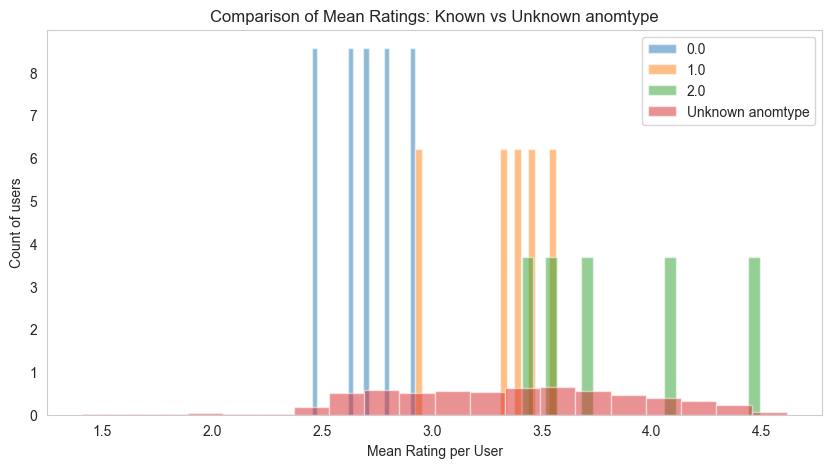

In [26]:
# Comparison of Mean Ratings: Known vs Unknown anomtype

# Step 1: compute mean rating per user from X
user_means = X_no_dupes.groupby("user")["rating"].mean().reset_index(name="mean_rating")

# Step 2: join with anomtype info
user_means = user_means.merge(y_cat, on="user", how="left")

# Step 3: create a "group" column (known vs unknown anomtype)
user_means["group"] = user_means["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

display(user_means)

plt.figure(figsize=(10, 5))
for group, data in user_means.groupby("group"):
    plt.hist(
        data["mean_rating"], 
        bins=20,
        alpha=0.5,
        density=True,
        label=group)

plt.xlabel("Mean Rating per User")
plt.ylabel("Count of users")
plt.title("Comparison of Mean Ratings: Known vs Unknown anomtype")
plt.legend()
plt.grid()
plt.show()

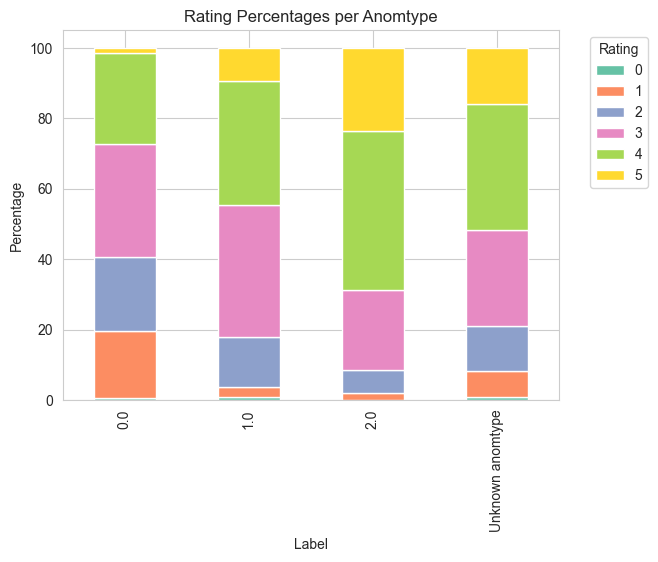

In [27]:
# Rating Percentages per Anomtype
# Might not be that relevant because we only have 15 rows in y_cat, just trying it out

merged_df = pd.merge(X, y_cat, on='user', how='left')
merged_df["anomtype"] = merged_df["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

rating_counts = merged_df.groupby(['anomtype', 'rating']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Rating Percentages per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

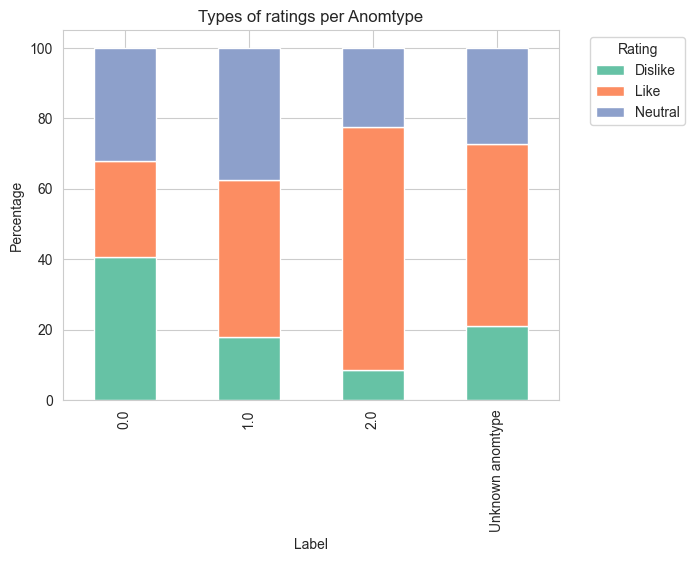

In [28]:
# We now group the ratings into categories of Dislike/Neutral/Like

def map_rating_category(r):
    if r in [0, 1, 2]:
        return "Dislike"
    elif r == 3:
        return "Neutral"
    else: 
        return "Like"

merged_df["rating_category"] = merged_df["rating"].apply(map_rating_category)

rating_counts = merged_df.groupby(['anomtype', 'rating_category']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Types of ratings per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

Our hypothesis seems to be true: it is evident from this graph that the different labels have different mean ratings and rating percentages. For example, anomtype 0 has an extremely small like percentage compared to that of anomtype 2. 
This suggests the need to create additional features such as mean_rating and possibly like_ratio/dislike_ratio/neutral_ratio for our models to more accurately predict the anomtype.

### Creating Basic Features

In [29]:
# Basic user features
df_user_features = X.groupby("user").agg(
    mean_rating=("rating", "mean"),
    median_rating=("rating", "median"),
    std_rating=("rating", "std"),
    count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
    count_neutral=("rating", lambda x: (x == 3).sum()),
    count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
    total_interactions=("rating", "count"),
)


display(df_user_features)

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions
user,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202
1,2.698507,3.0,0.838000,138,154,43,335
2,3.904580,4.0,0.576070,1,54,207,262
3,3.801325,4.0,1.081526,36,53,213,302
4,4.409357,4.0,0.633128,7,6,329,342
...,...,...,...,...,...,...,...
895,3.621849,4.0,0.782444,29,100,228,357
896,2.965957,3.0,1.165251,73,70,92,235
897,3.915663,4.0,0.878818,20,80,232,332


### Ratio Features

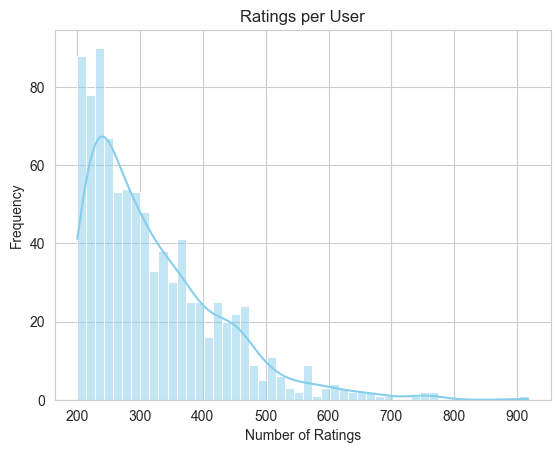

In [30]:
# Number of Ratings per User

user_ratings = X.groupby('user').size().reset_index(name='rating_count')
item_ratings = X.groupby(['item']).size().reset_index(name='rating_count')

sns.histplot(data=user_ratings, x='rating_count', bins=50, kde=True, color='skyblue')
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

plt.show()


A skewed distribution (many users with few interactions, few with many) further suggests that we need to create additional features such as ratios (like_ratio, dislike_ratio) to account for varying activity levels.

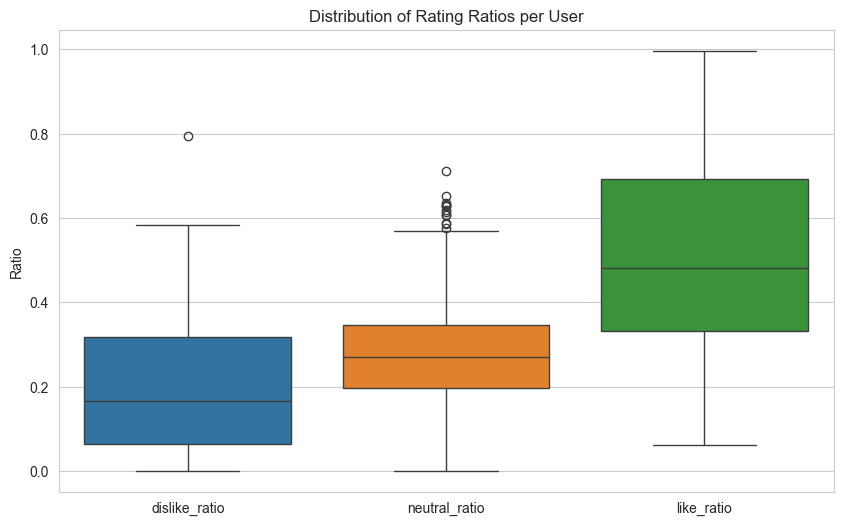

In [31]:
# Calculate counts per user for specific ratings
user_rating_counts = X.groupby('user')['rating'].agg(
    dislike=lambda x: ((x == 1) | (x == 2)).sum(),
    neutral=lambda x: (x == 3).sum(),
    like=lambda x: ((x == 4) | (x == 5)).sum()
).reset_index()

# Calculate ratios (relative to total interactions)
user_total = X.groupby('user')['rating'].count().reset_index(name='total')
user_rating_ratios = pd.merge(user_rating_counts, user_total, on='user')
for col in ['dislike', 'neutral', 'like']:
    user_rating_ratios[f'{col}_ratio'] = user_rating_ratios[col] / user_rating_ratios['total']

# Boxplot of ratios
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_rating_ratios[['dislike_ratio', 'neutral_ratio', 'like_ratio']])
plt.title('Distribution of Rating Ratios per User')
plt.ylabel('Ratio')
plt.show()

There are an extreme number of outliers in neutral_ratio which suggests it captures distinctive user patterns. If these extreme values correspond to meaningful class differences (anomtype), including this feature could help reduce the Bayes risk and improve accuracy.

### Creating Ratio Features

In [32]:
df_user_features["like_ratio"] = (
    df_user_features["count_like"] / df_user_features["total_interactions"]
)
df_user_features["dislike_ratio"] = (
    df_user_features["count_dislike"] / df_user_features["total_interactions"]
)
df_user_features["neutral_ratio"] = (
    df_user_features["count_neutral"] / df_user_features["total_interactions"]
)

display(df_user_features)

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio
user,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107
3,3.801325,4.0,1.081526,36,53,213,302,0.705298,0.119205,0.175497
4,4.409357,4.0,0.633128,7,6,329,342,0.961988,0.020468,0.017544
...,...,...,...,...,...,...,...,...,...,...
895,3.621849,4.0,0.782444,29,100,228,357,0.638655,0.081232,0.280112
896,2.965957,3.0,1.165251,73,70,92,235,0.391489,0.310638,0.297872
897,3.915663,4.0,0.878818,20,80,232,332,0.698795,0.060241,0.240964


### Distribution Features

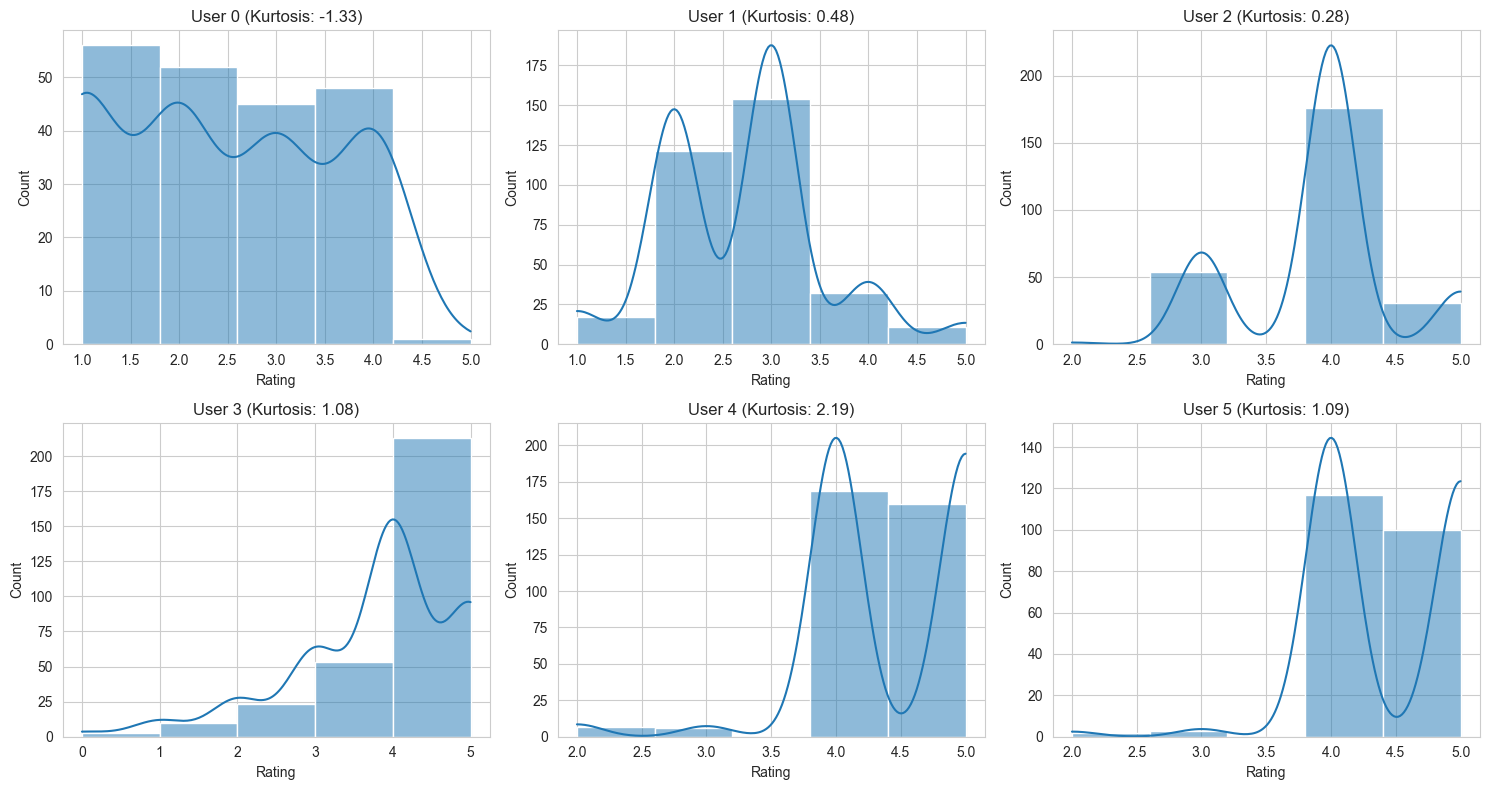

In [33]:
from scipy.stats import kurtosis

# Select a sample of users (e.g., first 6 users)
sample_users = X["user"].unique()[:6]

# Plot histograms of ratings for each user
plt.figure(figsize=(15, 8))
for i, user in enumerate(sample_users, 1):
    plt.subplot(2, 3, i)
    user_ratings = X[X["user"] == user]["rating"]
    sns.histplot(user_ratings, bins=5, kde=True)
    plt.title(f"User {user} (Kurtosis: {kurtosis(user_ratings):.2f})")
    plt.xlabel("Rating")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

Kurtosis is a statistical measure that describes the "tailedness" or shape of a distribution, particularly how much of the data is concentrated in the tails (extreme values) compared to the center. This feature captures the shape of a user’s rating distribution, which can reveal behavioral patterns that other features (like mean_rating or count_like) might miss.

Columns in df_kurtosis: Index(['user', 'rating_kurtosis'], dtype='object')
   user  rating_kurtosis
0     0        -1.329120
1     1         0.483190
2     2         0.281598
3     3         1.077512
4     4         2.194315


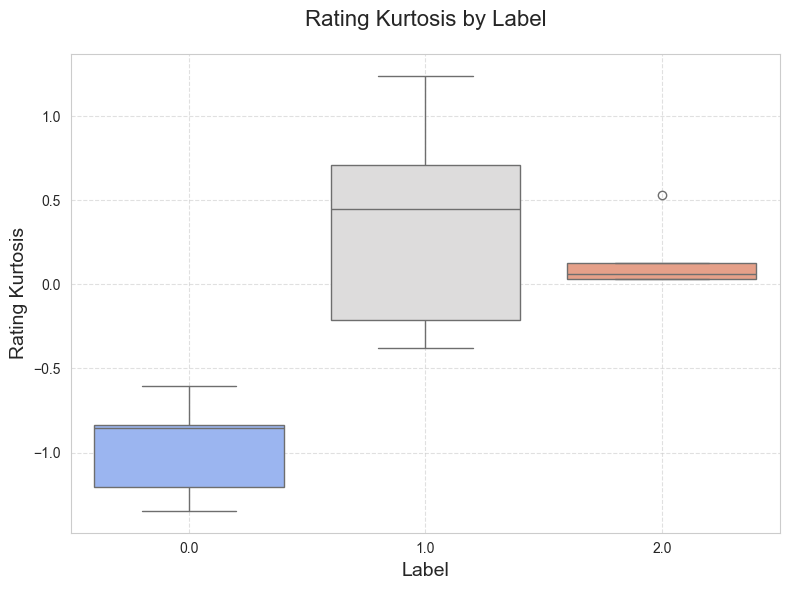

In [34]:
# Compute kurtosis for each user
user_kurtosis = X.groupby("user")["rating"].apply(lambda x: kurtosis(x)).fillna(0)

# Convert the Series to a DataFrame with the correct structure
df_kurtosis = pd.DataFrame({
    "user": user_kurtosis.index,
    "rating_kurtosis": user_kurtosis.values
})

# Verify the DataFrame
print("Columns in df_kurtosis:", df_kurtosis.columns)
print(df_kurtosis.head())

# Merge with the target labels (y)
df_plot = pd.merge(df_kurtosis, y_cat, on="user", how="left")

# Create a boxplot of kurtosis by label
plt.figure(figsize=(8, 6))
sns.boxplot(x="anomtype", y="rating_kurtosis", data=df_plot, palette="coolwarm")
plt.title("Rating Kurtosis by Label", fontsize=16, pad=20)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Rating Kurtosis", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

It is quite clear that there are varying levels of Kurtosis for each different label, so this could also be a useful factor in increasing accuracy of our models.

### Creating Distribution Features

In [35]:
df_user_features["rating_kurtosis"] = X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
)
df_user_features.head()

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,rating_kurtosis
user,,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772,-1.329120
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701,0.483190
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107,0.281598
3,3.801325,4.0,1.081526,36,53,213,302,0.705298,0.119205,0.175497,1.077512
4,4.409357,4.0,0.633128,7,6,329,342,0.961988,0.020468,0.017544,2.194315


### Final feature engineering function

In [ ]:
# Define the engineer_features function to add additional features

def engineer_features(df_X, df_y=None):
    df_X_no_dupes = df_X.drop_duplicates(subset=["user", "item"], keep="last")
    df_ratings = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
    all_items = range(0, 1000)
    df_ratings = df_ratings.reindex(columns=all_items, fill_value=-1)

    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
        count_neutral=("rating", lambda x: (x == 3).sum()),
        count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Fill NaN values in std_rating and rating_kurtosis
    df_user_features["std_rating"] = df_user_features["std_rating"].fillna(0)
    df_user_features["rating_kurtosis"] = df_user_features["rating_kurtosis"].fillna(0)

    final_df = pd.merge(df_ratings.reset_index(), df_user_features, on='user')
    
    if df_y is not None:
        df_merged = pd.merge(final_df.reset_index(), df_y, on="user", how="inner")
        return df_merged.drop(columns=["index"]).set_index("user")
    else:
        return final_df.set_index("user")


In [39]:
final_df = engineer_features(X, y)
display(final_df)

,0,1,2,3,4,5,6,7,8,9,...,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,rating_kurtosis,label
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,4.0,...,1.145320,108,45,49,202,0.242574,0.534653,0.222772,-1.329120,0.962817
1,-1.0,-1.0,2.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,-1.0,...,0.838000,138,154,43,335,0.128358,0.411940,0.459701,0.483190,0.031248
2,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.576070,1,54,207,262,0.790076,0.003817,0.206107,0.281598,0.068668
3,4.0,2.0,4.0,-1.0,1.0,3.0,-1.0,3.0,5.0,4.0,...,1.081526,36,53,213,302,0.705298,0.119205,0.175497,1.077512,0.349012
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,...,0.633128,7,6,329,342,0.961988,0.020468,0.017544,2.194315,0.917704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.782444,29,100,228,357,0.638655,0.081232,0.280112,0.925853,0.962911
896,4.0,-1.0,2.0,-1.0,4.0,-1.0,-1.0,-1.0,4.0,1.0,...,1.165251,73,70,92,235,0.391489,0.310638,0.297872,-0.883828,0.606888
897,5.0,3.0,4.0,3.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.878818,20,80,232,332,0.698795,0.060241,0.240964,-0.394032,0.334323
